ADVANCED DATA PREPROCESSING PIPELINE - ROUND 2

[STEP 1] Loading original cleaned data...
✓ Original dataset: 362,342 rows × 39 columns
✓ Output directory created: ../../results/benign_preprocessed/

[STEP 2] Investigating outliers in Rate feature...


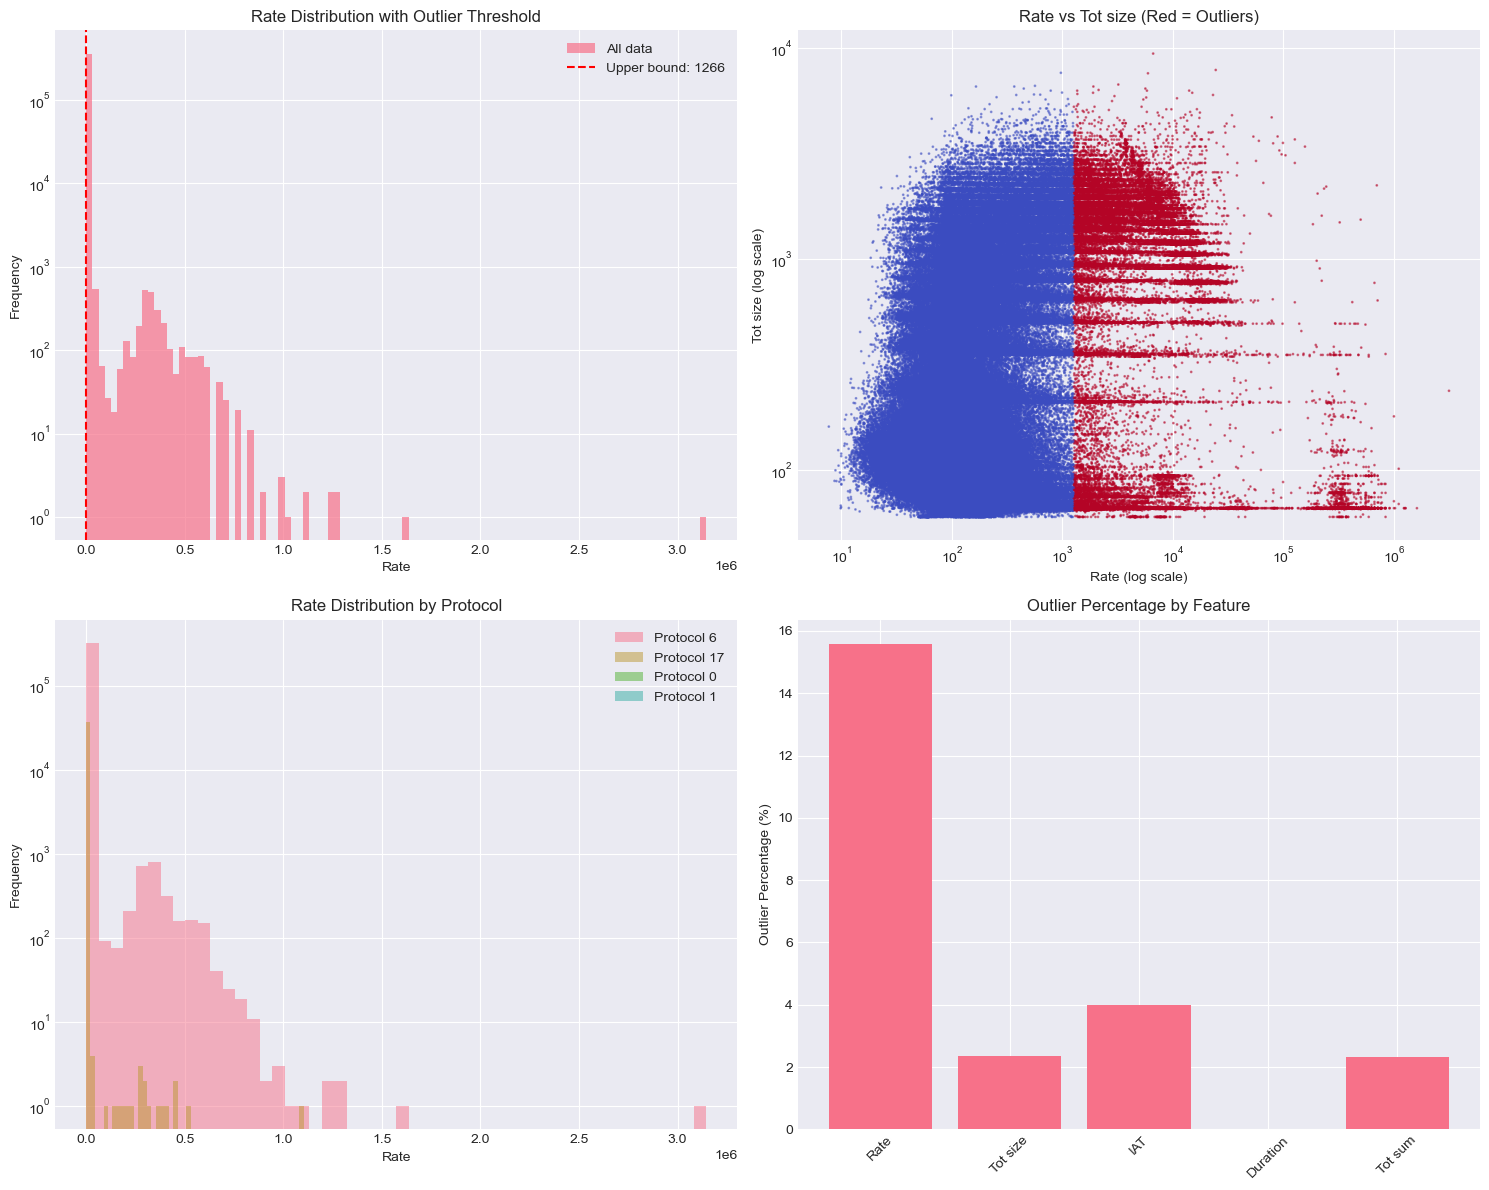


[STEP 3] Handling extreme outliers...

[STEP 4] Removing redundant features...

[STEP 5] Creating engineered features...

[STEP 6] Applying transformations...

[STEP 7] Creating multiple dataset versions...

[STEP 8] Creating validation plots...


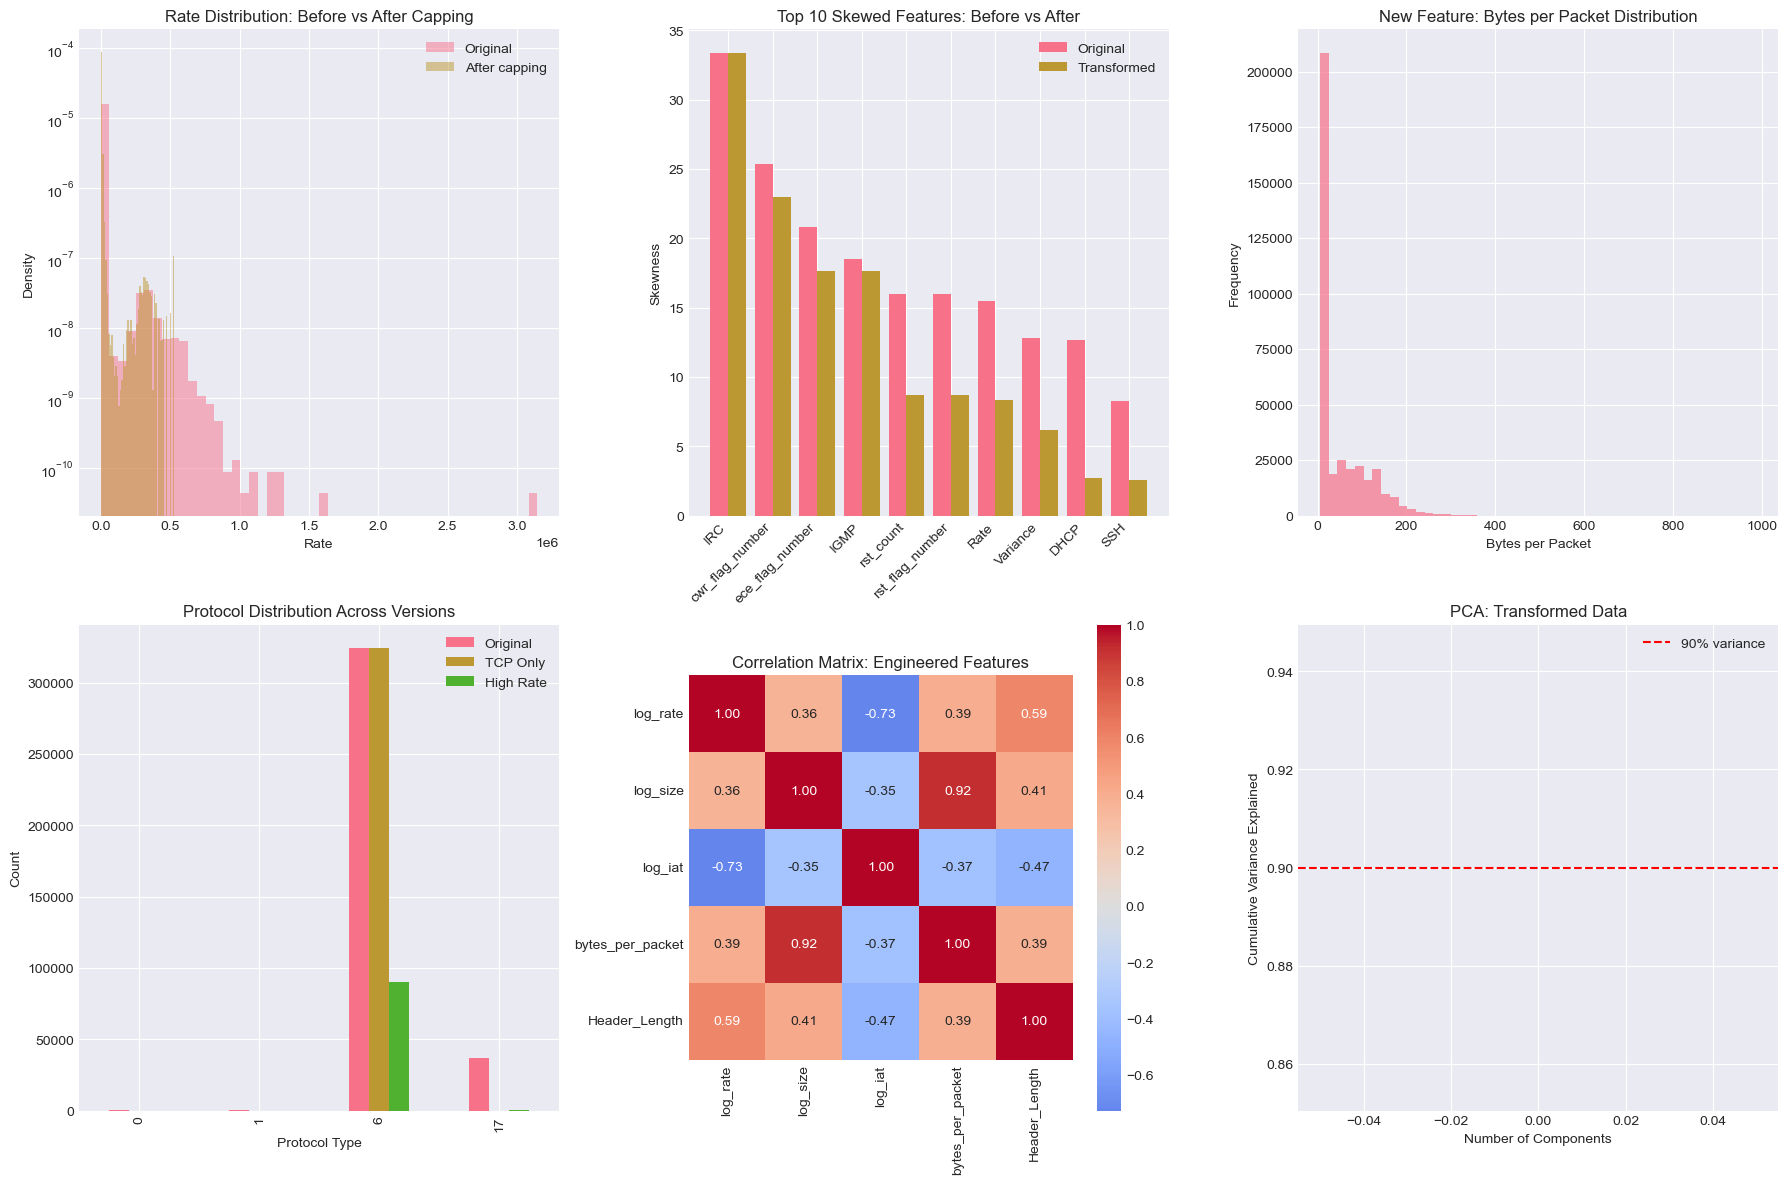


[STEP 9] Saving preprocessing pipeline parameters...

[FINAL] Saving preprocessing report...
✓ Preprocessing report saved to: ../../results/benign_preprocessed/preprocessing_report.md
✓ All datasets saved to: ../../results/benign_preprocessed/
✓ Visualizations saved to: ../../results/benign_preprocessed/

PREPROCESSING PIPELINE SUMMARY
Original dataset: (362342, 39)
Outliers capped: 3327 rows affected
Features removed: 2
Features engineered: 10
Dataset versions created: 5

Dataset versions:
  - benign_v1_full_preprocessed.csv: (362342, 47)
  - benign_v2_core_features.csv: (362342, 10)
  - benign_v3_tcp_only.csv: (324606, 47)
  - benign_v4_high_rate.csv: (90585, 47)
  - benign_v5_normalized.csv: (362342, 47)


In [3]:
# =====================================================================
# ADVANCED DATA PREPROCESSING PIPELINE FOR IoT ANOMALY DETECTION
# =====================================================================
# This script performs sophisticated data cleaning and feature engineering
# based on insights from our comprehensive analysis, preparing multiple
# dataset versions optimized for different anomaly detection approaches.
# =====================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as scipy_stats
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("=" * 80)
print("ADVANCED DATA PREPROCESSING PIPELINE - ROUND 2")
print("=" * 80)

# =====================================================================
# STEP 1: LOAD ORIGINAL CLEANED DATA
# =====================================================================
print("\n[STEP 1] Loading original cleaned data...")
benign_df_path = '../../results/clean_data/benign_df.csv'
df_original = pd.read_csv(benign_df_path)
print(f"✓ Original dataset: {df_original.shape[0]:,} rows × {df_original.shape[1]} columns")

# Create output directory for Round 2 cleaning
import os
output_dir = '../../results/benign_preprocessed/'
os.makedirs(output_dir, exist_ok=True)
print(f"✓ Output directory created: {output_dir}")

# Initialize preprocessing report
report = []
report.append("# Advanced Data Preprocessing Report\n")
report.append(f"**Generated on:** {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
report.append("---\n")

# =====================================================================
# STEP 2: INVESTIGATE OUTLIERS IN DEPTH
# =====================================================================
print("\n[STEP 2] Investigating outliers in Rate feature...")

# Analyze Rate outliers
Q1 = df_original['Rate'].quantile(0.25)
Q3 = df_original['Rate'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

rate_outliers = df_original[(df_original['Rate'] < lower_bound) | 
                           (df_original['Rate'] > upper_bound)]

report.append("## 1. Outlier Analysis\n")
report.append(f"### 1.1 Rate Feature Outliers\n")
report.append(f"- Total outliers: {len(rate_outliers):,} ({len(rate_outliers)/len(df_original)*100:.2f}%)\n")
report.append(f"- Lower bound: {lower_bound:.2f}\n")
report.append(f"- Upper bound: {upper_bound:.2f}\n")
report.append(f"- Max outlier value: {rate_outliers['Rate'].max():.2f}\n")
report.append(f"- Min outlier value: {rate_outliers['Rate'].min():.2f}\n")

# Analyze outlier patterns
outlier_protocols = rate_outliers['Protocol Type'].value_counts()
normal_protocols = df_original[~df_original.index.isin(rate_outliers.index)]['Protocol Type'].value_counts()

report.append("\n### 1.2 Outlier Protocol Distribution\n")
report.append("**Outliers:**\n")
for proto, count in outlier_protocols.items():
    report.append(f"- Protocol {proto}: {count/len(rate_outliers)*100:.2f}%\n")

# Visualize outlier distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Rate distribution with outlier threshold
ax1 = axes[0, 0]
ax1.hist(df_original['Rate'], bins=100, alpha=0.7, label='All data')
ax1.axvline(upper_bound, color='red', linestyle='--', label=f'Upper bound: {upper_bound:.0f}')
ax1.set_xlabel('Rate')
ax1.set_ylabel('Frequency')
ax1.set_title('Rate Distribution with Outlier Threshold')
ax1.set_yscale('log')
ax1.legend()

# Plot 2: Log-scale scatter of Rate vs Tot size
ax2 = axes[0, 1]
scatter = ax2.scatter(df_original['Rate'], df_original['Tot size'], 
                     c=df_original.index.isin(rate_outliers.index), 
                     cmap='coolwarm', alpha=0.5, s=1)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Rate (log scale)')
ax2.set_ylabel('Tot size (log scale)')
ax2.set_title('Rate vs Tot size (Red = Outliers)')

# Plot 3: Protocol-specific Rate distributions
ax3 = axes[1, 0]
for proto in df_original['Protocol Type'].unique():
    proto_data = df_original[df_original['Protocol Type'] == proto]['Rate']
    ax3.hist(proto_data, bins=50, alpha=0.5, label=f'Protocol {proto}')
ax3.set_xlabel('Rate')
ax3.set_ylabel('Frequency')
ax3.set_title('Rate Distribution by Protocol')
ax3.set_yscale('log')
ax3.legend()

# Plot 4: Outlier percentage by feature
ax4 = axes[1, 1]
outlier_features = ['Rate', 'Tot size', 'IAT', 'Duration', 'Tot sum']
outlier_percentages = []
for feature in outlier_features:
    if feature in df_original.columns:
        Q1 = df_original[feature].quantile(0.25)
        Q3 = df_original[feature].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df_original[(df_original[feature] < Q1 - 1.5*IQR) | 
                              (df_original[feature] > Q3 + 1.5*IQR)]
        outlier_percentages.append(len(outliers)/len(df_original)*100)
    else:
        outlier_percentages.append(0)

ax4.bar(range(len(outlier_features)), outlier_percentages)
ax4.set_xticks(range(len(outlier_features)))
ax4.set_xticklabels(outlier_features, rotation=45)
ax4.set_ylabel('Outlier Percentage (%)')
ax4.set_title('Outlier Percentage by Feature')

plt.tight_layout()
plt.savefig(f'{output_dir}outlier_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# =====================================================================
# STEP 3: HANDLE EXTREME OUTLIERS
# =====================================================================
print("\n[STEP 3] Handling extreme outliers...")

# Strategy: Cap extreme outliers at 99.9th percentile
df_cleaned = df_original.copy()

# Define features to cap
features_to_cap = ['Rate', 'Tot size', 'IAT', 'Tot sum', 'Min', 'Max', 'AVG', 'Std']
features_to_cap = [f for f in features_to_cap if f in df_cleaned.columns]

capping_stats = {}
for feature in features_to_cap:
    p999 = df_cleaned[feature].quantile(0.999)
    p001 = df_cleaned[feature].quantile(0.001)
    
    original_max = df_cleaned[feature].max()
    original_min = df_cleaned[feature].min()
    
    # Cap values
    df_cleaned[feature] = df_cleaned[feature].clip(lower=p001, upper=p999)
    
    capping_stats[feature] = {
        'original_max': original_max,
        'capped_max': p999,
        'original_min': original_min,
        'capped_min': p001,
        'affected_rows': ((df_original[feature] > p999) | (df_original[feature] < p001)).sum()
    }

report.append("\n## 2. Outlier Capping (99.9th Percentile)\n")
for feature, stats in capping_stats.items():
    report.append(f"\n**{feature}:**\n")
    report.append(f"- Original range: [{stats['original_min']:.2f}, {stats['original_max']:.2f}]\n")
    report.append(f"- Capped range: [{stats['capped_min']:.2f}, {stats['capped_max']:.2f}]\n")
    report.append(f"- Affected rows: {stats['affected_rows']:,}\n")

# =====================================================================
# STEP 4: REMOVE REDUNDANT FEATURES
# =====================================================================
print("\n[STEP 4] Removing redundant features...")

# Based on perfect correlations, remove redundant features
redundant_features = ['Tot sum', 'AVG']  # Keep Tot size as it's more intuitive
df_cleaned = df_cleaned.drop(columns=redundant_features, errors='ignore')

report.append("\n## 3. Feature Redundancy Removal\n")
report.append(f"- Removed features with perfect correlation: {', '.join(redundant_features)}\n")
report.append(f"- New shape: {df_cleaned.shape}\n")

# =====================================================================
# STEP 5: FEATURE ENGINEERING
# =====================================================================
print("\n[STEP 5] Creating engineered features...")

# Create new meaningful features
df_engineered = df_cleaned.copy()

# 1. Packet-based ratios
if 'Tot size' in df_engineered.columns and 'Number' in df_engineered.columns:
    df_engineered['bytes_per_packet'] = df_engineered['Tot size'] / (df_engineered['Number'] + 1)

if 'Number' in df_engineered.columns and 'Duration' in df_engineered.columns:
    df_engineered['packets_per_second'] = df_engineered['Number'] / (df_engineered['Duration'] + 0.001)

# 2. Rate-based features
if 'Rate' in df_engineered.columns:
    df_engineered['log_rate'] = np.log1p(df_engineered['Rate'])
    df_engineered['rate_zscore'] = zscore(df_engineered['Rate'])

# 3. Size-based features
if 'Tot size' in df_engineered.columns:
    df_engineered['log_size'] = np.log1p(df_engineered['Tot size'])
    df_engineered['size_category'] = pd.qcut(df_engineered['Tot size'], 
                                            q=5, labels=['XS', 'S', 'M', 'L', 'XL'])

# 4. Temporal features
if 'IAT' in df_engineered.columns:
    df_engineered['log_iat'] = np.log1p(df_engineered['IAT'])
    df_engineered['iat_coefficient_variation'] = (df_engineered['Std'] / 
                                                 (df_engineered['IAT'] + 0.001))

# 5. Flag-based features
flag_cols = [col for col in df_engineered.columns if 'flag' in col.lower()]
if flag_cols:
    df_engineered['total_flags'] = df_engineered[flag_cols].sum(axis=1)
    df_engineered['flag_diversity'] = (df_engineered[flag_cols] > 0).sum(axis=1)

# 6. Protocol-specific normalizations
for proto in df_engineered['Protocol Type'].unique():
    proto_mask = df_engineered['Protocol Type'] == proto
    if proto_mask.sum() > 100:  # Only if enough samples
        df_engineered.loc[proto_mask, 'rate_proto_zscore'] = zscore(
            df_engineered.loc[proto_mask, 'Rate']
        )

report.append("\n## 4. Feature Engineering\n")
report.append("### 4.1 New Features Created:\n")
new_features = [col for col in df_engineered.columns if col not in df_cleaned.columns]
for feature in new_features:
    report.append(f"- **{feature}**\n")

# =====================================================================
# STEP 6: APPLY TRANSFORMATIONS
# =====================================================================
print("\n[STEP 6] Applying transformations...")

# Identify highly skewed features
engineered_numeric_cols = df_engineered.select_dtypes(include=[np.number]).columns
skewness = df_engineered[engineered_numeric_cols].skew()
highly_skewed = skewness[abs(skewness) > 2].index.tolist()

# Apply appropriate transformations
df_transformed = df_engineered.copy()

# Use PowerTransformer for highly skewed features
power_transformer = PowerTransformer(method='yeo-johnson', standardize=False)
features_to_transform = [f for f in highly_skewed if f not in ['Protocol Type'] and 
                        not f.startswith('log_') and not f.endswith('_zscore')]

if features_to_transform:
    df_transformed[features_to_transform] = power_transformer.fit_transform(
        df_transformed[features_to_transform]
    )

report.append("\n## 5. Transformations Applied\n")
report.append(f"- Power transformation (Yeo-Johnson) applied to {len(features_to_transform)} features\n")
report.append(f"- Features: {', '.join(features_to_transform[:5])}...\n")

# =====================================================================
# STEP 7: CREATE MULTIPLE DATASET VERSIONS
# =====================================================================
print("\n[STEP 7] Creating multiple dataset versions...")

# Version 1: Full preprocessed dataset
df_v1_full = df_transformed.copy()

# Version 2: Core features only (for lightweight models)
core_features = ['Rate', 'Tot size', 'IAT', 'Number', 'Duration', 
                'Header_Length', 'Protocol Type', 'Time_To_Live',
                'bytes_per_packet', 'packets_per_second', 'log_rate', 'log_size']
core_features = [f for f in core_features if f in df_transformed.columns]
df_v2_core = df_transformed[core_features].copy()

# Version 3: TCP-only dataset
df_v3_tcp = df_transformed[df_transformed['Protocol Type'] == 6].copy()

# Version 4: High-rate traffic only (potential DDoS focus)
high_rate_threshold = df_transformed['Rate'].quantile(0.75)
df_v4_highrate = df_transformed[df_transformed['Rate'] > high_rate_threshold].copy()

# Version 5: Normalized dataset (all features scaled)
scaler = RobustScaler()  # Robust to outliers
# Get numeric features from the transformed dataframe
numeric_features_v5 = df_transformed.select_dtypes(include=[np.number]).columns
df_v5_normalized = df_transformed.copy()
df_v5_normalized[numeric_features_v5] = scaler.fit_transform(df_transformed[numeric_features_v5])

# Save all versions
datasets = {
    'benign_v1_full_preprocessed.csv': df_v1_full,
    'benign_v2_core_features.csv': df_v2_core,
    'benign_v3_tcp_only.csv': df_v3_tcp,
    'benign_v4_high_rate.csv': df_v4_highrate,
    'benign_v5_normalized.csv': df_v5_normalized
}

report.append("\n## 6. Dataset Versions Created\n")
for filename, df in datasets.items():
    filepath = os.path.join(output_dir, filename)
    df.to_csv(filepath, index=False)
    report.append(f"\n### {filename}\n")
    report.append(f"- Shape: {df.shape}\n")
    report.append(f"- Size: {df.memory_usage().sum() / 1024**2:.2f} MB\n")
    report.append(f"- Description: {filename.replace('.csv', '').replace('_', ' ').title()}\n")

# =====================================================================
# STEP 8: VALIDATION PLOTS
# =====================================================================
print("\n[STEP 8] Creating validation plots...")

# Create before/after comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Compare Rate distribution
ax1 = axes[0, 0]
ax1.hist(df_original['Rate'], bins=50, alpha=0.5, label='Original', density=True)
ax1.hist(df_cleaned['Rate'], bins=50, alpha=0.5, label='After capping', density=True)
ax1.set_xlabel('Rate')
ax1.set_ylabel('Density')
ax1.set_title('Rate Distribution: Before vs After Capping')
ax1.set_yscale('log')
ax1.legend()

# Compare skewness
ax2 = axes[0, 1]
# Get numeric columns from each dataframe
original_numeric = df_original.select_dtypes(include=[np.number]).columns
transformed_numeric = df_transformed.select_dtypes(include=[np.number]).columns
# Find common columns for fair comparison
common_numeric = list(set(original_numeric) & set(transformed_numeric))
original_skew = df_original[common_numeric].skew().sort_values(ascending=False).head(10)
cleaned_skew = df_transformed[common_numeric].skew().sort_values(ascending=False).head(10)
x = range(len(original_skew))
ax2.bar([i-0.2 for i in x], original_skew.values, width=0.4, label='Original')
ax2.bar([i+0.2 for i in x], cleaned_skew.values, width=0.4, label='Transformed')
ax2.set_xticks(x)
ax2.set_xticklabels(original_skew.index, rotation=45, ha='right')
ax2.set_ylabel('Skewness')
ax2.set_title('Top 10 Skewed Features: Before vs After')
ax2.legend()

# New feature distributions
ax3 = axes[0, 2]
if 'bytes_per_packet' in df_engineered.columns:
    ax3.hist(df_engineered['bytes_per_packet'], bins=50, alpha=0.7)
    ax3.set_xlabel('Bytes per Packet')
    ax3.set_ylabel('Frequency')
    ax3.set_title('New Feature: Bytes per Packet Distribution')

# Protocol distribution in different versions
ax4 = axes[1, 0]
proto_counts = pd.DataFrame({
    'Original': df_original['Protocol Type'].value_counts(),
    'TCP Only': df_v3_tcp['Protocol Type'].value_counts() if len(df_v3_tcp) > 0 else pd.Series(),
    'High Rate': df_v4_highrate['Protocol Type'].value_counts()
})
proto_counts.plot(kind='bar', ax=ax4)
ax4.set_xlabel('Protocol Type')
ax4.set_ylabel('Count')
ax4.set_title('Protocol Distribution Across Versions')
ax4.legend()

# Feature correlation heatmap (transformed data)
ax5 = axes[1, 1]
core_corr_features = ['log_rate', 'log_size', 'log_iat', 'bytes_per_packet', 
                     'packets_per_second', 'Header_Length']
core_corr_features = [f for f in core_corr_features if f in df_transformed.columns]
if len(core_corr_features) > 2:
    corr_matrix = df_transformed[core_corr_features].corr()
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                center=0, ax=ax5, square=True)
    ax5.set_title('Correlation Matrix: Engineered Features')

# PCA variance explained
ax6 = axes[1, 2]
# Get numeric features from normalized data
pca_numeric_features = df_v5_normalized.select_dtypes(include=[np.number]).columns
if len(pca_numeric_features) > 5:
    pca_data = df_v5_normalized[pca_numeric_features].fillna(0)
    pca = PCA(n_components=min(10, len(pca_numeric_features)))
    pca.fit(pca_data)
    cumvar = np.cumsum(pca.explained_variance_ratio_)
    ax6.plot(range(1, len(cumvar) + 1), cumvar, 'bo-')
    ax6.axhline(y=0.90, color='r', linestyle='--', label='90% variance')
    ax6.set_xlabel('Number of Components')
    ax6.set_ylabel('Cumulative Variance Explained')
    ax6.set_title('PCA: Transformed Data')
    ax6.legend()
    ax6.grid(True)

plt.tight_layout()
plt.savefig(f'{output_dir}preprocessing_validation.png', dpi=300, bbox_inches='tight')
plt.show()

# =====================================================================
# STEP 9: SAVE PREPROCESSING PIPELINE
# =====================================================================
print("\n[STEP 9] Saving preprocessing pipeline parameters...")

# Save transformation parameters for future use
import pickle

pipeline_params = {
    'power_transformer': power_transformer,
    'robust_scaler': scaler,
    'capping_stats': capping_stats,
    'feature_names': {
        'original': df_original.columns.tolist(),
        'engineered': new_features,
        'core': core_features,
        'transformed': features_to_transform
    },
    'thresholds': {
        'high_rate': high_rate_threshold
    }
}

with open(f'{output_dir}preprocessing_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline_params, f)

report.append("\n## 7. Pipeline Parameters Saved\n")
report.append("- Power transformer fitted on training data\n")
report.append("- Robust scaler parameters saved\n")
report.append("- Feature names and thresholds preserved\n")
report.append("- Ready for consistent preprocessing of new data\n")

# =====================================================================
# SAVE REPORT
# =====================================================================
print("\n[FINAL] Saving preprocessing report...")

report.append("\n## 8. Summary Statistics\n")
report.append(f"- Original features: {len(df_original.columns)}\n")
report.append(f"- Features after redundancy removal: {len(df_cleaned.columns)}\n")
report.append(f"- Features after engineering: {len(df_engineered.columns)}\n")
report.append(f"- New engineered features: {len(new_features)}\n")
report.append(f"- Features transformed: {len(features_to_transform)}\n")
report.append("\n---\n")
report.append("**Preprocessing pipeline completed successfully!**\n")

with open(f'{output_dir}preprocessing_report.md', 'w') as f:
    f.writelines(report)

print(f"✓ Preprocessing report saved to: {output_dir}preprocessing_report.md")
print(f"✓ All datasets saved to: {output_dir}")
print(f"✓ Visualizations saved to: {output_dir}")

# Display final summary
print("\n" + "="*80)
print("PREPROCESSING PIPELINE SUMMARY")
print("="*80)
print(f"Original dataset: {df_original.shape}")
print(f"Outliers capped: {sum([stats['affected_rows'] for stats in capping_stats.values()])} rows affected")
print(f"Features removed: {len(redundant_features)}")
print(f"Features engineered: {len(new_features)}")
print(f"Dataset versions created: {len(datasets)}")
print("\nDataset versions:")
for filename, df in datasets.items():
    print(f"  - {filename}: {df.shape}")
print("="*80)